In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [3]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


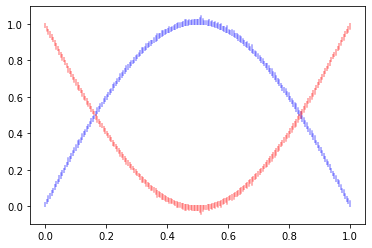

In [4]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [5]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    type_id = 0 if rand_traj_ind<num_demos/2 else 1
    
    if device.type == 'cuda':
        return observations.float().cuda(), type_id, targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), type_id, targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    type_id = 0 if ind<num_val/2 else 1
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda(), type_id
    else:
        return x, y, type_id

In [6]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, type_id, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        if type_id == 0:
            return self.f0(z_target)
        else:
            return self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def validate():
    verr=torch.zeros(num_val)
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y, type_id = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj = torch.zeros_like(val_y)
            pred_traj[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred = model(observation, type_id, torch.unsqueeze(val_x[t], 0))
                pred_traj[t, :], _ = pred.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std

            verr[i] = torch.sum((val_y - pred_traj) ** 2)
    return torch.mean(verr)

In [ ]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
iters = 10000000

losses = []
min_verr = 1e6

for i in range(iters):
    obss, type_id, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, type_id, tx)
    loss = log_prob_loss(ty, ty_preds)
    
    if type_id == 0:
        model.f0.requires_grad = True
        model.f1.requires_grad = False
    else:
        model.f0.requires_grad = False
        model.f1.requires_grad = True
    
    loss.backward()
    optimizer.step()
    
    if (i)%val_after_iter == 0:
        verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            torch.save(model.state_dict(), f'{path}/best_model.pt')

0: 87.77172088623047
2500: 20.375835418701172
5000: 18.35936737060547
7500: 17.891437530517578
10000: 16.2183780670166
12500: 13.026853561401367
15000: 10.107561111450195
17500: 8.372598648071289
20000: 3.9225006103515625
22500: 1.25498366355896
25000: 0.3386470377445221
27500: 0.19038009643554688
30000: 0.33879759907722473
32500: 0.058322034776210785
35000: 0.21227869391441345
37500: 0.08944071829319
40000: 0.03958363085985184
42500: 0.20290932059288025
45000: 0.050662122666835785
47500: 0.22705379128456116
50000: 0.07235394418239594
52500: 0.08021141588687897
55000: 0.04996401444077492
57500: 0.03620674088597298
60000: 0.11545345932245255
62500: 0.1160108894109726
65000: 0.10614114999771118
67500: 0.02360786497592926
70000: 0.025239059701561928
72500: 0.03728531673550606
75000: 0.017700349912047386
77500: 0.11359439790248871
80000: 0.03111237660050392
82500: 0.03198003023862839
85000: 0.03676323965191841
87500: 0.06392873823642731
90000: 0.06311045587062836
92500: 0.17546595633029938

725000: 0.012595169246196747
727500: 0.022122615948319435
730000: 0.028200140222907066
732500: 0.016236279159784317
735000: 0.00915028527379036
737500: 0.010148905217647552
740000: 0.014835229143500328
742500: 0.008309343829751015
745000: 0.007857253775000572
747500: 0.010461119003593922
750000: 0.017489856109023094
752500: 0.015369814820587635
755000: 0.01079610362648964
757500: 0.014603654853999615
760000: 0.009146911092102528
762500: 0.011362534016370773
765000: 0.014495456591248512
767500: 0.010994073003530502
770000: 0.00868308823555708
772500: 0.00938334595412016
775000: 0.012071041390299797
777500: 0.008576609194278717
780000: 0.01668006367981434
782500: 0.014830941334366798
785000: 0.014653904363512993
787500: 0.011157439090311527
790000: 0.013081511482596397
792500: 0.01054038293659687
795000: 0.008626970462501049
797500: 0.01826287992298603
800000: 0.017007922753691673
802500: 0.016057129949331284
805000: 0.0106939896941185
807500: 0.012671507894992828
810000: 0.0178998336195

1425000: 0.01940758153796196
1427500: 0.010435141623020172
1430000: 0.01389321219176054
1432500: 0.011204558424651623
1435000: 0.009128676727414131
1437500: 0.011958370916545391
1440000: 0.008000390604138374
1442500: 0.01029096357524395
1445000: 0.03948962315917015
1447500: 0.009359143674373627
1450000: 0.009558325633406639
1452500: 0.010950271040201187
1455000: 0.011373773217201233
1457500: 0.009846463799476624
1460000: 0.012301614508032799
1462500: 0.008386610075831413
1465000: 0.008263220079243183
1467500: 0.012172479182481766
1470000: 0.010779939591884613
1472500: 0.009373745881021023
1475000: 0.01489140372723341
1477500: 0.012508055195212364
1480000: 0.012330451980233192
1482500: 0.008067691698670387
1485000: 0.008443102240562439
1487500: 0.007985353469848633
1490000: 0.01097782887518406
1492500: 0.009443567134439945
1495000: 0.008322538807988167
1497500: 0.013087378814816475
1500000: 0.014285850338637829
1502500: 0.015336806885898113
1505000: 0.009760146029293537
1507500: 0.01520

2112500: 0.0074920617043972015
2115000: 0.010712157003581524
2117500: 0.01041404064744711
2120000: 0.00958315096795559
2122500: 0.008273554034531116
2125000: 0.015034923329949379
2127500: 0.007329688873142004
2130000: 0.011523159220814705
2132500: 0.00976938009262085
2135000: 0.009050894528627396
2137500: 0.008902175351977348
2140000: 0.019149689003825188
2142500: 0.01035222876816988
2145000: 0.009023807942867279
2147500: 0.007508367300033569
2150000: 0.014928805641829967
2152500: 0.011365832760930061
2155000: 0.008418282493948936
2157500: 0.009585496969521046
2160000: 0.009489992633461952
2162500: 0.008031046949326992
2165000: 0.01044439896941185
2167500: 0.009933637455105782
2170000: 0.014315580949187279
2172500: 0.009935780428349972
2175000: 0.007256743498146534
2177500: 0.007404421456158161
2180000: 0.009050296619534492
2182500: 0.012340727262198925
2185000: 0.00838363915681839
2187500: 0.010235536843538284
2190000: 0.008793946355581284
2192500: 0.012103022076189518
2195000: 0.0086

2800000: 0.008233091793954372
2802500: 0.00799124501645565
2805000: 0.007641998119652271
2807500: 0.009342273697257042
2810000: 0.009190483018755913
2812500: 0.010508131235837936
2815000: 0.013477104716002941
2817500: 0.008920134976506233
2820000: 0.00915465597063303
2822500: 0.0093377148732543
2825000: 0.007949000224471092
2827500: 0.00894231628626585
2830000: 0.009059512987732887
2832500: 0.008092133328318596
2835000: 0.009712044149637222
2837500: 0.010894023813307285
2840000: 0.007405995391309261
2842500: 0.013317895121872425
2845000: 0.008355433121323586
2847500: 0.00755567941814661
2850000: 0.009748640470206738
2852500: 0.00959822442382574
2855000: 0.00864817388355732
2857500: 0.011129898019134998
2860000: 0.01239771954715252
2862500: 0.012259693816304207
2865000: 0.008120087906718254
2867500: 0.007615880575031042
2870000: 0.011108122766017914
2872500: 0.010824359953403473
2875000: 0.013527351431548595
2877500: 0.008277369663119316
2880000: 0.011511249467730522
2882500: 0.01367105

3487500: 0.0093980822712183
3490000: 0.008065949194133282
3492500: 0.009382481686770916
3495000: 0.0085997823625803
3497500: 0.00879366509616375
3500000: 0.008320552296936512
3502500: 0.009940525516867638
3505000: 0.00721640745177865
3507500: 0.009521683678030968
3510000: 0.010476869530975819
3512500: 0.01183754950761795
3515000: 0.009186162613332272
3517500: 0.017999516800045967
3520000: 0.007645426783710718
3522500: 0.011237718164920807
3525000: 0.007938678376376629
3527500: 0.007309748791158199
3530000: 0.00890631414949894
3532500: 0.008339997380971909
3535000: 0.008475925773382187
3537500: 0.010810966603457928
3540000: 0.00830414704978466
3542500: 0.00879864115267992
3545000: 0.008405439555644989
3547500: 0.00847897119820118
3550000: 0.00898151658475399
3552500: 0.008295996114611626
3555000: 0.010225698351860046
3557500: 0.008968550711870193
3560000: 0.00845912005752325
3562500: 0.015709294006228447
3565000: 0.008020540699362755
3567500: 0.008338932879269123
3570000: 0.007561077829

In [ ]:
plt.plot(range(len(losses[:50])), losses[:50])